In [18]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import eigh
from scipy import spatial
from sklearn import datasets
np.random.seed(21)

# Assignment 2:PCA, eigenfaces and face recognition 

Face perception is very important in human social interactions. It is facilitated by complex neuronal interactions utilizing extensive and diverse areas of the brain in order to support the sophisticated cognitive skills, including recognition of familiar faces, identification of diverse facial expressions and interpretation of emotions.

In signal processing, manipulating and interpreting images of human faces also play an important role. This is both in order to simulate the information processing that occur in the brain but also in a wide range of intelligent systems and services, that for instance implements face detection and face recognition.

Face images are very high-dimensional data if we consider each pixel position as a feature. For instance, images with a resolution of $64\times 64$ pixels will have $64 \times 64 = 4096$ dimensions. However, it is easy to realize that only relatively few of the possible high-dimensional images will actually correspond to a possible face, i.e. most possible images will not depict a 'real' face.

In this exercise we are interested in finding a more effective representation, based on quantifying the  subspace of possible face images instead of the space of all $64\times 64$  sized images. To identify such a subspace, we will use principal component analysis (PCA) on a dataset of real face images. 
This procedure allows us to capture the directions that describe most of the variance in actual face images, hence effectively reducing the dimensionality to a subspace of the possible ('real looking') faces.
To illustrate this, we use a standard dataset of face images collected at the AT&T Laboratories in
Cambridge between the year 1992 and 1994. The dataset contains 10 grayscaled face images for each of 40 persons (400 images total). All images are $64\times 64$ pixels and the gray scale of each pixel is represented by a real value $[0,1]$. 

## Contents

1. [Classifier](#Classifier)
2. [Most similar image](#Most-similar-image)
3. [Test Images](#third-example)
4. [Different number of eigenfaces](#Different-number-of-eigenfaces)
5. [Variance and performance](#Variance-and-performance)
6. [Mis-classification features](#Mis-classification-features)
7. [Five most similar images](#Five-most-similar-images)


###  The Olivetti data set

Let's take a look at how the dataset looks by looking at the first 2 subjects. In general, high quality data would be images that are taken under the same lighting conditions and where facial features (such as eyes, nose and mouth) are aligned across the images.


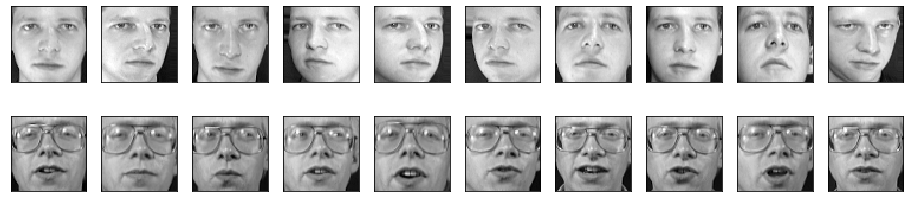

In [4]:
data = datasets.fetch_olivetti_faces()
data = data.images.reshape(data.images.shape[0],data.images.shape[1]**2)
data = data.T

fig = plt.figure(figsize=(16,80))
for i in range(20):    
    ax = fig.add_subplot(40,10,i+1,xticks = [], yticks = [])
    image_i = data[:,i];
    ax.imshow(image_i.reshape(64,64), cmap=plt.cm.gray)

### Test and training data

To later evaluate the dimensionality reduction and test face recognition, we will split the data-set into a training and test set. We will only perform PCA on the training data. This code will

- Split the data-set into a training and test set, such that they both contain five unique images of each person (every other image from the full dataset is used as test).  

- Plot a small example of both the training and test images


A look at the training set


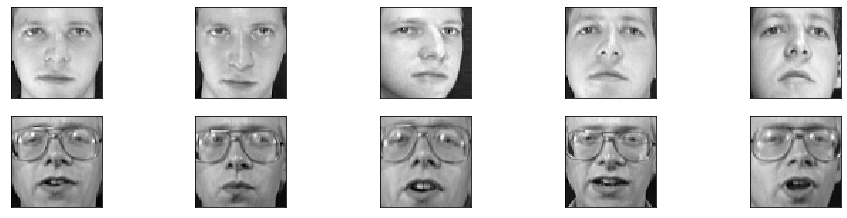

A look at the test set


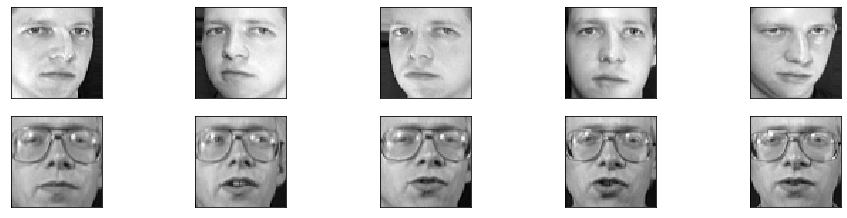

In [10]:
Xdata = data[:,0::2] #training data
Ydata = data[:,1::2] #test data

#plot training set
print('A look at the training set')
fig = plt.figure(figsize=(16,80))
for i in range(10):    
    ax = fig.add_subplot(40,5,i+1,xticks = [], yticks = [])
    image_i = Xdata[:,i];
    ax.imshow(image_i.reshape(64,64), cmap=plt.cm.gray)
plt.show()
#plot test set
print('A look at the test set')
fig = plt.figure(figsize=(16,80))
for i in range(10):    
    ax = fig.add_subplot(40,5,i+1,xticks = [], yticks = [])
    image_i = Ydata[:,i];
    ax.imshow(image_i.reshape(64,64), cmap=plt.cm.gray)
plt.show()    

###  Normalizing the data
The purpose of principal component analysis (PCA) is to project the training data onto directions which maximize the variance. Before applying PCA it is custom to normalize the data to avoid that the scales of single features dominate the first principle components.

For face images, normalization is performed by computing the average training image $\widehat{\mathbf{x}}$ and subtracting it from each of the training images, $\mathbf{x}_i - \widehat{\mathbf{x}}$. 

Let $\mathbf{X}$ be the matrix of the normalized training data, such that each column $i$ represents the normalized image vector $\mathbf{x}_i - \widehat{\mathbf{x}}$. Likewise, let $\mathbf{Y}$ be the matrix of normalized test data.

- The code computes the average of the training data, $\widehat{\mathbf{x}}$, and plots it as a $64\times 64$ image. 

- The code also computes and plots the average of the test data $\widehat{\mathbf{y}}$. Note how similar is is with  $\widehat{\mathbf{x}}$.



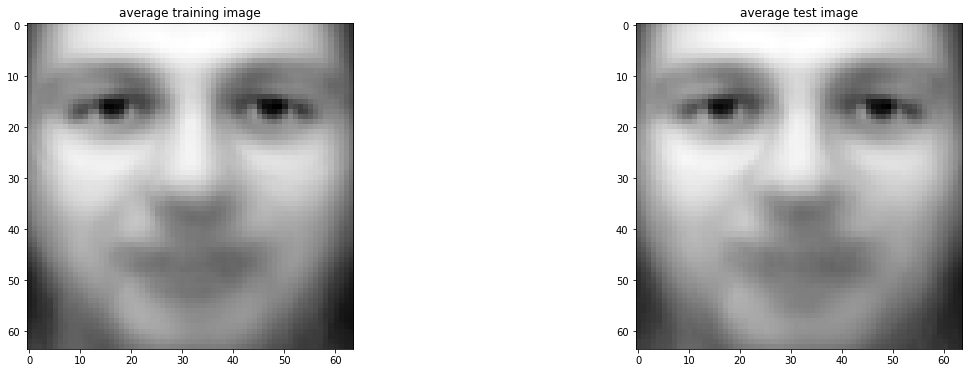

In [12]:
X_mean = np.mean(Xdata,axis=1)
X = Xdata - X_mean[:, None]
Y_mean = np.mean(Ydata,axis=1)
Y = Ydata - Y_mean[:, None]

plt.figure(figsize=(20, 6))
plt.subplot(1,2, 1)
plt.imshow( X_mean.reshape(64,64),cmap = plt.cm.gray)
plt.title('average training image')

plt.subplot(1,2, 2)
plt.imshow( Y_mean.reshape(64,64),cmap = plt.cm.gray)
plt.title('average test image');


###  Principal component analysis and eigenfaces

Let $\lambda_1,\ldots,\lambda_d$ be the ordered set of eigenvalues of the covariance matrix of the training data, such that $\lambda_1 \geq \lambda_2 \geq \ldots \geq \lambda_d $. If there exists a number $m$, such that $\lambda_i \gg \lambda_j, i = 1,\ldots m$, and $j=m+1,\ldots,d$, then the data-set can be transformed to a coordinate system, where most of the signal variance is in an $m$-dimensional linear subspace spanned by the $m$'th first eigenvectors in the ordered list. Recall that this transformation is given by the eigenvectors of the covariance matrix ($\bf V$):

$$  \tilde{\mathbf{x}}_i = \mathbf{V}^{\top}(\mathbf{x}_i - \widehat{\mathbf{x}}). $$

If we extract only the first $m$ components of the transformed datavector $\tilde{\bf x}$ we obtain a signal that carries most of the variation of the original signal.

For face images the eigenvectors are referred to as eigenfaces. They have the same dimensionality as the original images and can hence be plotted as images. The percentage of variance explained by a given eigenface can be computed as the corresponding eigenvalue divided by the sum of all eigenvalues.
 
You can see that the significant eigenfaces code for the most primitive/large facial features, while features like eyebrows and the mouth are next. With just around $60$ eigenfaces, we can explain $90\%$ of the variance in the faces. If show the with the smallest eigenvalues, we will see that some of least useful eigenfaces are mostly noise / white. Let's take a look at some of the most significant eigenfaces.

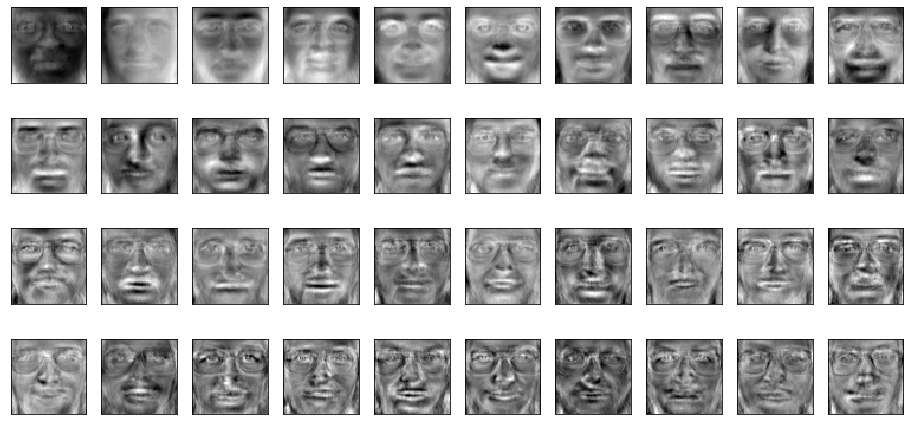

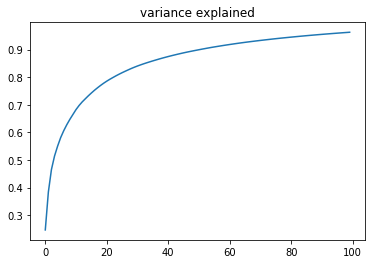

In [13]:
#compute covariance matrix
S = np.cov(X)

#obtain eigenvalues and eigenvectors
eigenValues, eigenVectors = eigh(S)

# sort eigenvectors according to eigenvalues
sort_idx = np.argsort(eigenValues)[::-1]
eigenValues = eigenValues[sort_idx]
eigenVectors = eigenVectors[:, sort_idx]


#plot eigenfaces
fig = plt.figure(figsize=(16,20))
for i in range(40):    
    ax = fig.add_subplot(10,10,i+1,xticks = [], yticks = [])    
    im = eigenVectors[:,i]
    ax.imshow(im.reshape(64,64),cmap = plt.cm.gray)
plt.grid()
plt.show();
    
#plot cummulative variance explained    
summ = eigenValues.sum()
cumsum = 0
total_var_explained = np.zeros(100)
for i in range(100):    
    cumsum += eigenValues[i]
    total_var_explained[i]=(cumsum/summ)
plt.plot(total_var_explained)
plt.title('variance explained');


### Decomposing faces using eigenfaces

The code below takes 5 random faces and reconstructs them using $M$ eigenfaces (principal components).

It is noteworthy that the different faces require a different amount of principal components. Those most similar to the mean image require the lowest amount of principal components.

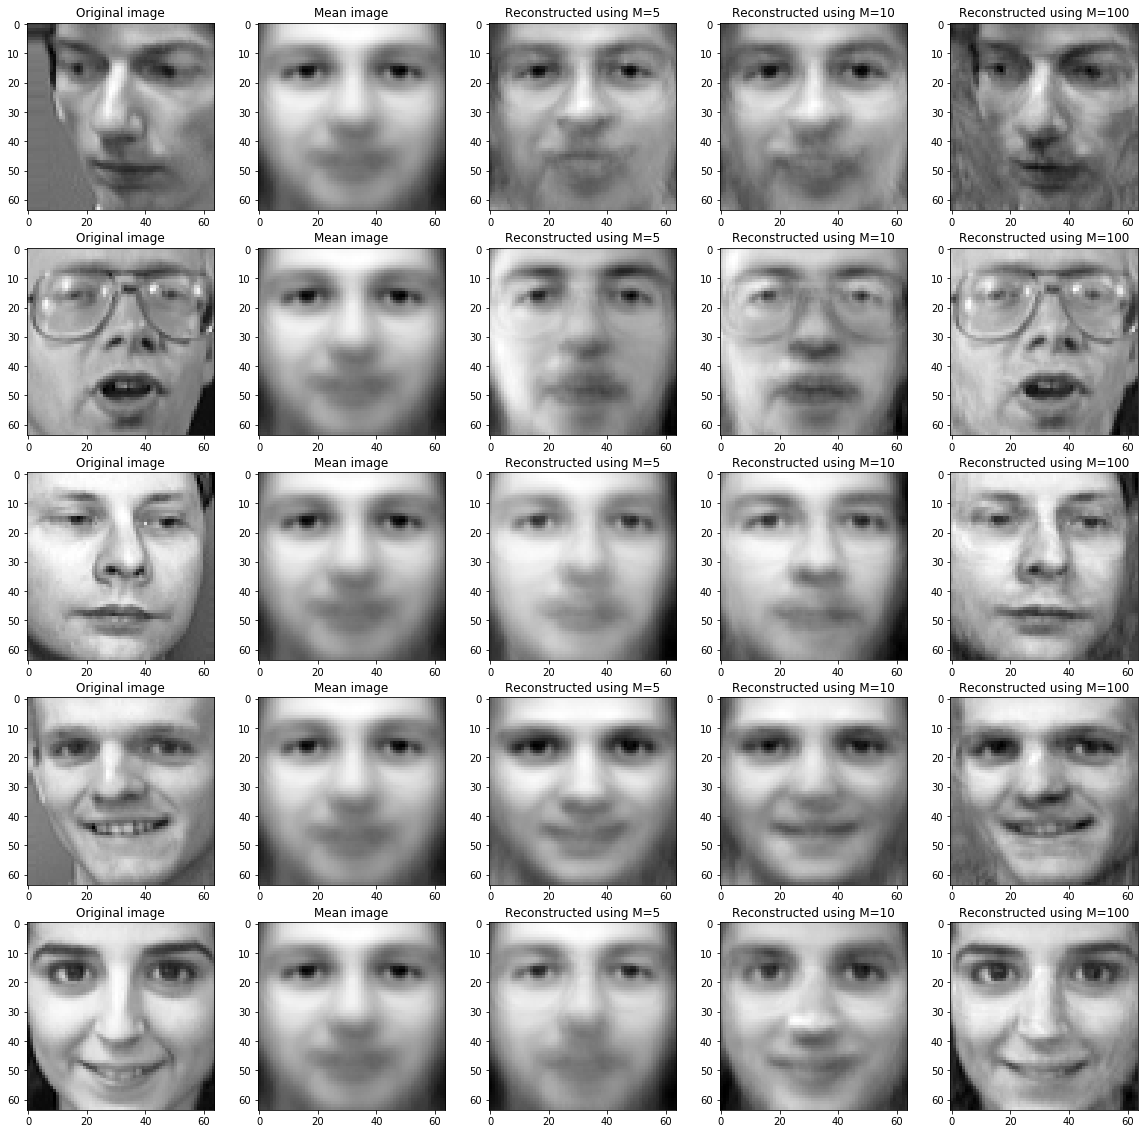

In [19]:
randperm = np.random.permutation(Xdata.shape[1])

plt.figure(figsize=(20, 20))
for i in range(5):
    
    j = randperm[i]
    # show image
    ax = plt.subplot2grid((5, 5), (i, 0))
    
    ax.imshow(Xdata[:, j].reshape(64,64),cmap = plt.cm.gray)
    plt.title('Original image')
    
    # show mean value
    ax = plt.subplot2grid((5, 5), (i, 1))
    ax.imshow(X_mean.reshape(64,64),cmap = plt.cm.gray)
    plt.title('Mean image')
        
    for idx_m, m in enumerate([5, 10, 100]):
    
        z = eigenVectors.T@X[:, j]
        x_reconstruction = X_mean + eigenVectors[:, :m]@z[:m]
    
        ax = plt.subplot2grid((5, 5), (i, 2 + idx_m))
        ax.imshow(x_reconstruction.reshape(64,64),cmap = plt.cm.gray)
        
        plt.title('Reconstructed using M=%d' % m)
    

## Classifier

Cosine similarity
$$
\text{similarity} = \frac{\mathbf{A}\cdot \mathbf{B}}{\left\lVert \mathbf{A}\right\rVert\left\lVert \mathbf{B}\right\rVert}
$$

In [20]:
zxs = np.array([eigenVectors.T@X[:, i] for i in range(200)])
zys = np.array([eigenVectors.T@Y[:, i] for i in range(200)])

In [67]:
from scipy.stats import mode
def classifyImage(idx, k = None, top_n = 1):
    zy = zys[:,:k]
    zx = zxs[:,:k]
    similarities = [spatial.distance.cosine(zy[idx], zx[i]) for i in range(200)]
    top_n_pairs = dict(sorted(enumerate(similarities), key = lambda x: x[1])[:top_n])
    most_similar_subject = mode([arg//5 for arg in top_n_pairs]).mode[0]
    
    correct_clf = idx//5 == most_similar_subject
    return (most_similar_subject, correct_clf)

## Most similar image

In [22]:
classifiedImages = [classifyImage(i) for i in range(200)]

## Test Images

Try out your function for different test images. Plot the test image together with the training image that was found to be most similar. Also print whether the two images depict the same, in that case the title is green, otherwise red.

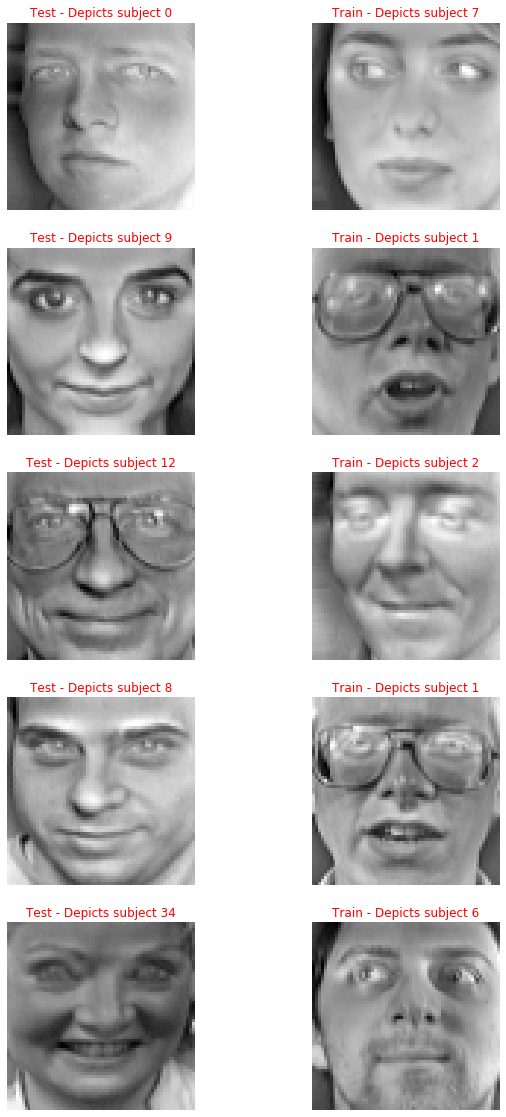

In [45]:
test_images_idx = [1,48,64,42,171]
fig, axs = plt.subplots(5,2, figsize = (10,20))

for ax, im in zip(axs, test_images_idx):
    i = 0
    true_label = im//5
    predicted_label = classifyImage(im)[0]//5
    if true_label == predicted_label:
        color = 'green'
    else:
        color = 'red'
    
    ax[i].imshow(Y[:,im].reshape(64,64), cmap = plt.cm.gray)
    ax[i].set_title(f'Test - Depicts subject {true_label}', color=color)
    ax[i].axis('off')
    ax[i+1].imshow(X[:,classifiedImages[im][0]].reshape(64,64), cmap = plt.cm.gray)
    ax[i+1].set_title(f'Train - Depicts subject {predicted_label}', color=color)
    ax[i+1].axis('off')
    
    i += 1

## Different number of eigenfaces

Compute and plot the number of miss-classifications when using different number of eigenfaces $K$, for instance in the range $K \in [1, 100]$

In [24]:
no_miss_clf = []
time_spend = []
from time import time


for k in range(1,101):
    t1 = time()
    miss_clf = [classifyImage(idx, k)[1] for idx in range(200)].count(False)
    t2 = time()
    time_spend.append(t2-t1)
    if k % 10 == 0:
        print(f'{k}', end = " ")
    no_miss_clf.append(miss_clf)

10 20 30 40 50 60 70 80 90 100 

## Variance and performance

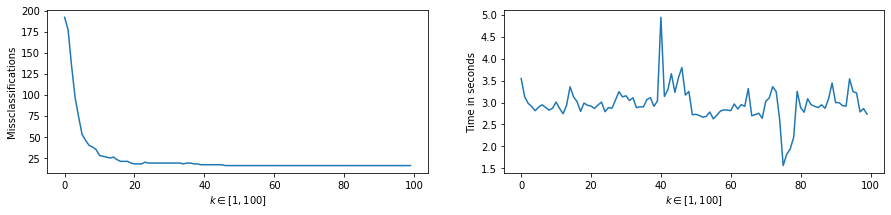

In [60]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(no_miss_clf)
plt.xlabel('$k\in[1,100]$')
plt.ylabel('Missclassifications')

plt.subplot(1,2,2)
plt.plot(time_spend)
plt.xlabel('$k\in[1,100]$')
plt.ylabel('Time in seconds')
plt.show()

## Mis-classification features

When using 20 eigenfaces

In [94]:
classifiedImages = [classifyImage(i, 20) for i in range(200)]
missclassified = [(i, im[0]) for i, im in enumerate(classifiedImages) if im[1] == False]
print("number of misclassifications", len(missclassified))

number of misclassifications 19


### Pairs of misclassified images in two columns

Here we are showing 40 of some the misclassified images (again when classifying with 20 eigenfaces).

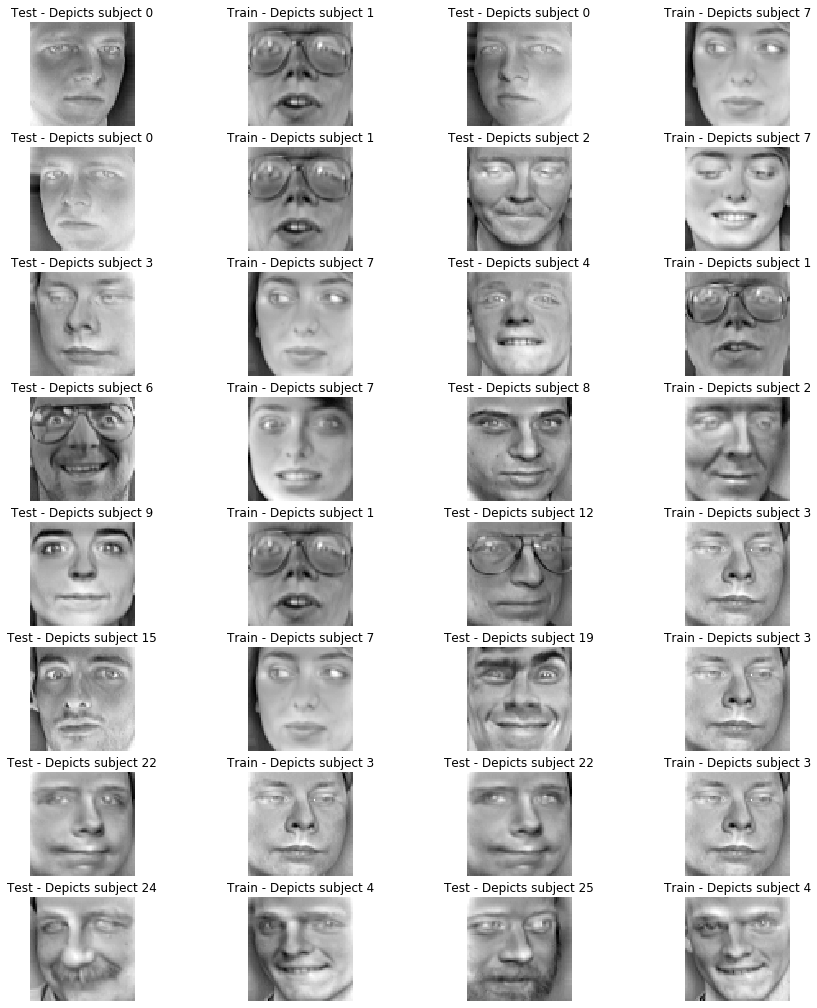

In [95]:
fig, axs = plt.subplots(8,4, figsize=(15,18))

for miss_clf, (ax1, ax2) in zip(missclassified, axs.reshape(-1,2)):
    
    ax1.imshow(Y[:,miss_clf[0]].reshape(64,64), cmap = plt.cm.gray)
    ax1.set_title(f'Test - Depicts subject {miss_clf[0]//5}')
    ax1.axis('off')
    ax2.imshow(X[:,miss_clf[1]].reshape(64,64), cmap = plt.cm.gray)
    ax2.set_title(f'Train - Depicts subject {miss_clf[1]//5}')
    ax2.axis('off')

It seems like the classifier is having trouble with the most generic round faces which are similar to the mean face, as well as faces with glasses - likely because there are far fewer faces with glasses in the dataset.

Let's try reconstructing the faces above with 20 eigenfaces to get a better understanding of why the classifier might be having trouble.

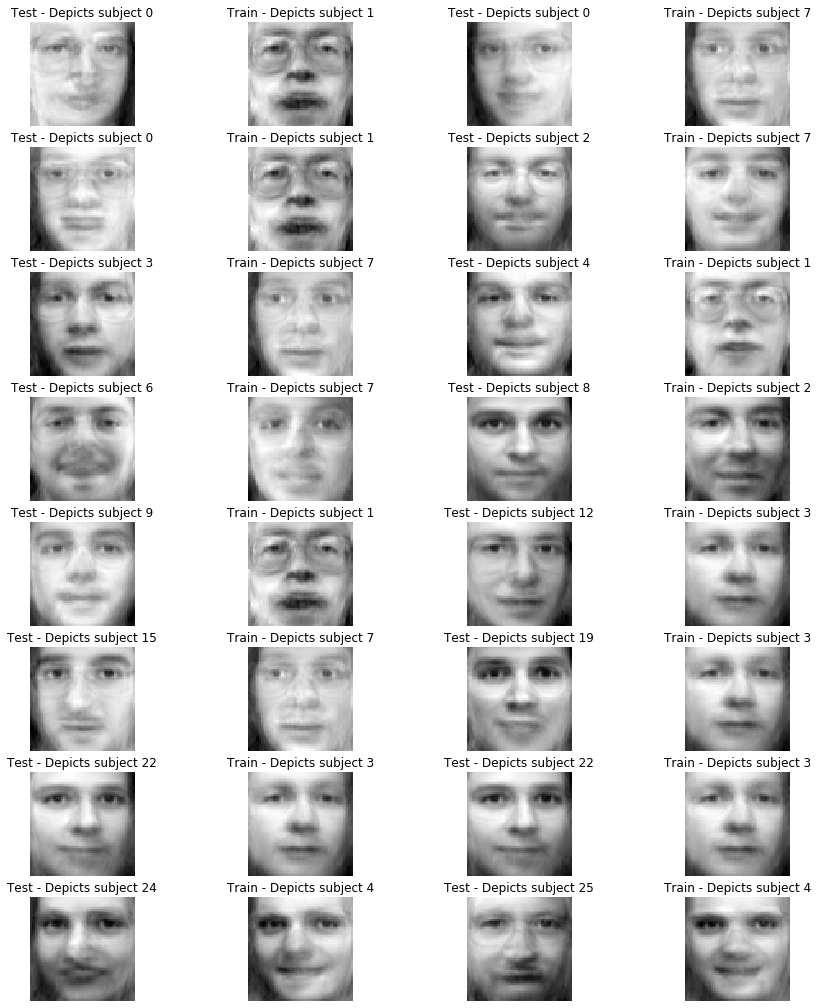

In [101]:
fig, axs = plt.subplots(8,4, figsize=(15,18))
m = 20

for miss_clf, (ax1, ax2) in zip(missclassified, axs.reshape(-1,2)):
    
    z = eigenVectors.T@Y[:, miss_clf[0]]
    test_reconstruction = X_mean + eigenVectors[:, :m]@z[:m]
    z = eigenVectors.T@X[:, miss_clf[1]]
    train_reconstruction = X_mean + eigenVectors[:, :m]@z[:m]
    
    ax1.imshow(test_reconstruction.reshape(64,64), cmap = plt.cm.gray)
    ax1.set_title(f'Test - Depicts subject {miss_clf[0]//5}')
    ax1.axis('off')
    ax2.imshow(train_reconstruction.reshape(64,64), cmap = plt.cm.gray)
    ax2.set_title(f'Train - Depicts subject {miss_clf[1]//5}')
    ax2.axis('off')

Now it is much easier to understand that the classifier having trouble with these particular faces. When they are projected with 20 eigenfaces, they look really similar.

## Five most similar images

In [30]:
n_missclassifications = []
for n in range(1,51):
    n_missclassifications.append([classifyImage(i, top_n = n)[1] for i in range(200)].count(False) / 200 * 100)

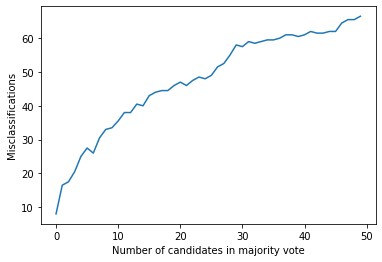

In [31]:
plt.plot(n_missclassifications)
plt.ylabel('Misclassifications')
plt.xlabel('Number of candidates in majority vote')
plt.show()